In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

!pip install tensorflow-hub
!pip install tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

     |████████████████████████████████| 3.3MB 3.5MB/s 
Version:  2.2.0-rc1
Eager mode:  True
Hub version:  0.7.0
GPU is available


In [0]:
# Using google colab - this first step is for loading in the data from my personal Drive

# Login with google credentials

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Handle errors from too many requests

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

# The ID for my personal Drive folder is 1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx
# I am now listing the ID numbers for the files in this folder to find the data files

#file_list = drive.ListFile({'q': "'1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx' in parents and trashed=false"}).GetList()
#for file1 in file_list:
#  print('title: %s, id: %s' % (file1['title'], file1['id']))


# Now that I have the ID files, load the files

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1mZ2VUPqvPujfO87V9u8_mH_ugTTWDFxml-TDJcO6qeA/edit#gid=906545618')
sheet = wb.sheet1
data = sheet.get_all_values()


In [0]:
# Import NTLK libraries

import numpy as np
import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag

import re
from sklearn.feature_extraction.text import CountVectorizer
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
# convert DF to Pandas, remove top row with column IDs, limit to only labelled entries

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df[:700]
#df['Label'], df['Tweet']

df = df.reset_index()

target = df['Label'].astype(int)
tweets = df['Tweet'].copy(deep=True)

In [0]:
target.describe()

# 34% are 0, then 66% are 1

count    700.000000
mean       0.341429
std        0.474528
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Label, dtype: float64

In [0]:
wn = nltk.WordNetLemmatizer()
import string

## Function to clean entries - lowercase, lemmatize, tokenize, drop stop words, recombine

def clean_articles(doc):
    for column in range(len(doc)):
        
        #doc[column] = doc[column].astype(str)
        doc[column] = doc[column].replace('[^\w\s]','')
        
        doc[column] = doc[column].lower()
        # removing punctuation worsens results a lot
        #doc[column] = ''.join([str(item) for item in doc[column] if item not in string.punctuation])
        
        #doc[column] = doc[column].replace(np.nan, ' ', regex=True)

        doc[column] = nltk.word_tokenize(doc[column])
        doc[column] = lemmatize_text(doc[column])

        doc[column] = [token for token in doc[column] if token not in stop_words]     
        doc[column] = ' '.join([str(item) for item in doc[column] ])
    return doc

def lemmatize_text(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

In [0]:
# Get cleaned data
data_clean = clean_articles(tweets)

In [0]:
# reunify cleaned data and target

merge_df = pd.concat([data_clean, target], axis=1, sort=False)

# shuffle the data

train_shuffle_0 = merge_df[merge_df["Label"] == 0].sample(frac=0.8, random_state=np.random.seed())
train_shuffle_1 = merge_df[merge_df["Label"] == 1].sample(frac=0.8, random_state=np.random.seed())

test_shuffle_0 = merge_df[merge_df["Label"] == 0].drop(train_shuffle_0.index)
test_shuffle_1 = merge_df[merge_df["Label"] == 1].drop(train_shuffle_1.index)

train_shuffle = pd.concat([train_shuffle_0, train_shuffle_1], axis=0, sort=False).sample(frac=1)
test_shuffle = pd.concat([test_shuffle_0, test_shuffle_1], axis=0, sort=False).sample(frac=1)

data_clean_train = train_shuffle['Tweet']
data_clean_test = test_shuffle['Tweet']

# train test split

target_train = train_shuffle['Label']
target_test = test_shuffle['Label']


In [0]:
target_test.describe()

count    140.000000
mean       0.342857
std        0.476369
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Label, dtype: float64

In [0]:
# Convert pandas to TF data - thanks ben
train_data = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(data_clean_train.values, tf.string),
            tf.cast(target_train.values, tf.int32)
        )
    )
)

test_data = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(data_clean_test.values, tf.string),
            tf.cast(target_test.values, tf.int32)
        )
    )
)

train_data = train_data.shuffle(5000).batch(32)
test_data = test_data.shuffle(5000).batch(32)

In [0]:
from tensorflow import keras

## Transfer learning

#embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[],
                           input_shape=[], dtype=tf.string)

## Set up model

model = tf.keras.Sequential()

model.add(hub_layer)
model.add(tf.keras.layers.Dense(1000, activation ='relu'))
model.add(tf.keras.layers.Dense(200, activation ='relu'))
keras.layers.Dropout(0.2, noise_shape=None, seed=None)
model.add(tf.keras.layers.Dense(16, activation ='relu'))
keras.layers.Dropout(0.2, noise_shape=None, seed=None)
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 1000)              129000    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               200200    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                3216      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 124,975,121
Trainable params: 332,433
Non-trainable params: 124,642,688
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss =tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['binary_accuracy'])

In [0]:
history = model.fit(train_data, epochs=100, verbose=1)

Epoch 1/100
18/18 [==============================] - 0s 12ms/step - loss: 0.7269 - binary_accuracy: 0.6464
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.6766 - binary_accuracy: 0.6589
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6598 - binary_accuracy: 0.6589
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.6541 - binary_accuracy: 0.7000
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6469 - binary_accuracy: 0.8625
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 0.6405 - binary_accuracy: 0.8821
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6198 - binary_accuracy: 0.9143
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6006 - binary_accuracy: 0.9393
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5976 - binary_accuracy: 0.9446
Epoch 10/100
18/18 [=================

In [0]:
results = model.evaluate(test_data, verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))


5/5 - 0s - loss: 0.6039 - binary_accuracy: 0.8929
loss: 0.604
binary_accuracy: 0.893


In [0]:
results

[0.6038973927497864, 0.8928571343421936]

In [0]:
model.predict(["I hated it"])

array([[2.7867325e-34]], dtype=float32)

In [0]:
model.predict(["loved it!"])

array([[2.8276788e-21]], dtype=float32)

In [0]:
model.predict(["It Was a glorious triumph"])

array([[3.9321082e-36]], dtype=float32)

In [0]:
model.predict(["I thought it Was a glorious piece of complete crap!"])

array([[5.854035e-31]], dtype=float32)

In [0]:
model.predict_classes(["It was great"])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0]], dtype=int32)

In [0]:
model.predict_classes(["It was shit"])

array([[0]], dtype=int32)

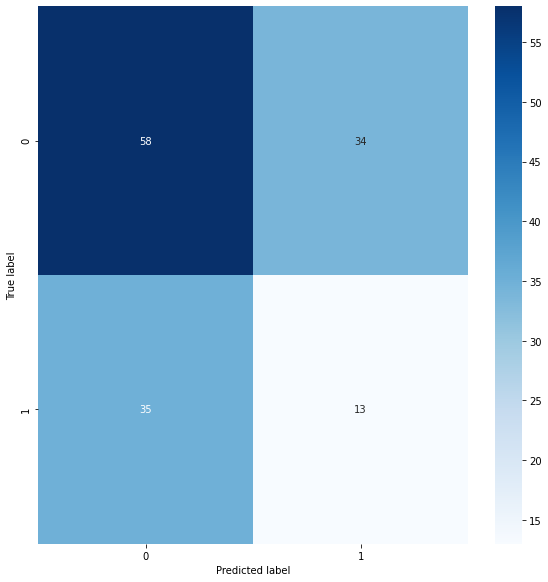

(140,)

In [0]:
## Confusion matrix - not working

y_pred=model.predict_classes(test_data).reshape(len(model.predict_classes(test_data),))

con_mat = tf.math.confusion_matrix(labels=target_test, predictions=y_pred).numpy()
#con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat)

con_mat_df
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

y_pred.shape